# Predicting Pipe Incidences in Spain

## Introduction

We were given the task of predicting the incidence of gas pipes in Spain. The training data provided includes the characteristics of each pipe as well as previous inspections, including the severity of the damage found. The dataset consists of approximately 6.5 million rows, representing inspections on the pipe network up until the end of 2020. Our goal is to use this data to predict incidences on the revisions that took place in 2021 and 2022, which total around 900K rows, one for each pipe. We plan to use the AUC metric (area under the ROC curve) to evaluate the performance of our predictions. Our project aims to develop a model that can accurately predict gas pipe failures, which could help prevent accidents and ensure the safety of the network.

## Exploring and Cleaning the Data

After importing all our necessary libaries we import our network and inspections csv´s. We decided to encode the 'Gas Type', 'Province', 'Material' and 'BoolBridle'. For our model we decided to drop the 'Town' as we felt it was not adding more value than only having 'Province' as a georgraphic factor, as well as the 'NumConnectionsUnder' columns as we did not feel it added value relative to additional noise.

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_score
from sklearn import metrics

import random
from statistics import mean

from scipy import stats
from scipy.stats import mode, norm, skew
from math import sqrt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import datathonfunctions
import seaborn as sns
import pandas_profiling



In [192]:
d = pd.read_csv('network.csv', sep = ',')
d.head(5)

,PipeId,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,489616,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.0,7.792,0.4,0,0,False
1,489645,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,90.0,2.080,0.4,0,0,False
2,489646,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,90.0,111.173,0.4,3,0,False
3,519950,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,200.0,14.304,0.4,0,0,False
4,1332439,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,160.0,22.669,0.4,1,0,False


In [193]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

def encode_type_gas(x):
    if x == 'Gas natural':
        return 1
    if x == 'Gas propano':
        return 2
    


def encode_type_bridle(x):
    if True:
        return 1
    if False:
        return 2
    


def encode_type_material(x):
    if x == 'PE':
        return 1
    if x == 'AO':
        return 2
    if x == 'PN':
        return 3
    if x == 'CU':
        return 4
    if x == 'FD':
        return 5
    if x == 'ZD':
        return 6
    if x == 'PV':
        return 7
    if x == 'PA':
        return 8
    if x == 'FI':
        return 9
    if x == 'FG':
        return 10
    if x == 'FO':
        return 11


# Standardize The Predictions Dataset
def scale_dataset_predi(dataframe, oversample=False):
    X = dataframe.copy()
    # y = dataframe['Incidence']
    # X = X.drop(['Incidence'], axis=1)
    
    X_Selected = X[['Diameter', 'Length', 'NumConnections', 'Pressure']]

    scaler = StandardScaler()
    X_Selected_Scaled = scaler.fit_transform(X_Selected)
    
    X[['Diameter', 'Length', 'NumConnections', 'Pressure']] = X_Selected_Scaled

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X,y)

    data = X.copy()
    # data['Incidence'] = y

    # data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data


In [194]:
def encode_type_province(x):
    Province_dict = {"Barcelona": 1, "Valencia": 2, "Madrid": 3, "Girona": 4, "Tarragona": 5, "Alicante": 6, "La Coruña": 7, "Sevilla": 8, "Toledo": 9, "Lleida": 10, "Pontevedra": 11, "Valladolid": 12, "Castellón": 13, "Málaga": 14, "Ciudad Real": 15, "León": 16, "La Rioja": 17, "Córdoba": 18, "Salamanca": 19, "Burgos": 20, "Granada": 21, "Guadalajara": 22, "Albacete": 23, "Lugo": 24, "Palencia": 25, "Zamora": 26, "Huelva": 27, "Orense": 28, "Cádiz": 29, "Segovia": 30, "Jaén": 31, "Cuenca": 32, "Zaragoza": 33, "Soria": 34, "Almeria": 35, "Huesca": 36, "Teruel": 37, "Avila": 38}
    
    return Province_dict[x]

d["Province"] = d["Province"].apply(encode_type_province)
d.drop(['NumConnectionsUnder', 'Town'], axis=1, inplace=True)

In [195]:

d['GasType'] = d['GasType'].transform(encode_type_gas)
d['BoolBridle'] = d['BoolBridle'].transform(encode_type_bridle)
d['Material'] = d['Material'].transform(encode_type_material)



In [196]:

d.head(5)

,PipeId,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
0,489616,15,2012,1,1,63.0,7.792,0.4,0,1
1,489645,15,2012,1,1,90.0,2.080,0.4,0,1
2,489646,15,2012,1,1,90.0,111.173,0.4,3,1
3,519950,15,2012,1,1,200.0,14.304,0.4,0,1
4,1332439,15,2012,1,1,160.0,22.669,0.4,1,1


In [197]:
d2 = pd.read_csv('inspections.csv', sep = ',')


/var/folders/qd/gcz7v8b52fjf42gd3137l9g40000gn/T/ipykernel_29431/2728298680.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = d2.corr()


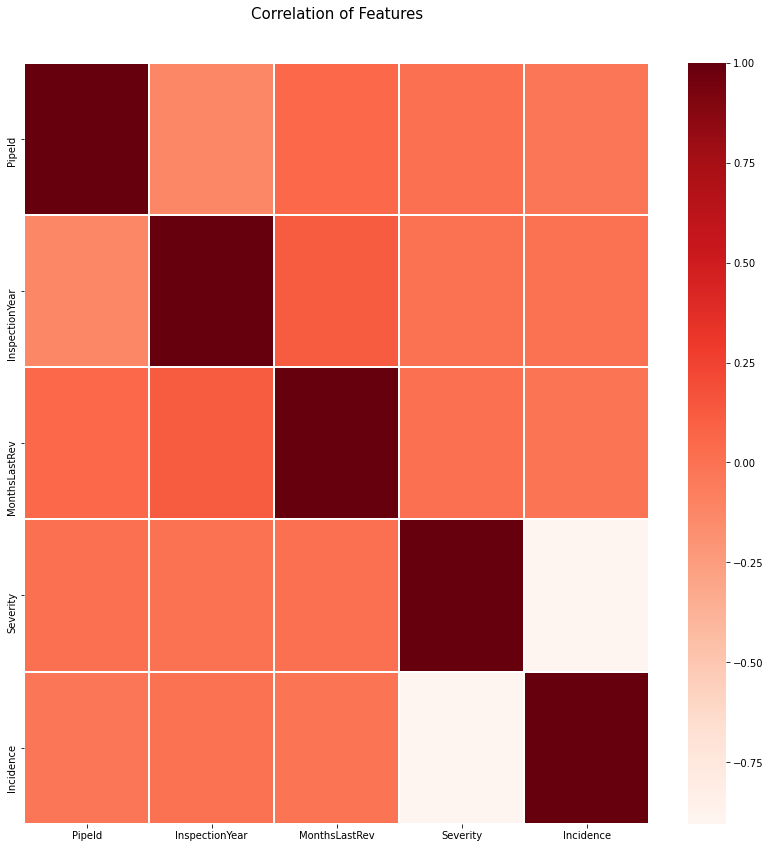

In [198]:
plt.figure(figsize = (14,14))
plt.title('Correlation of Features', y=1.05, size=15)
corr = d2.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

In [199]:
d2 = d2.drop(['MaintenanceId', 'InspectionYear', "Severity", "MonthsLastRev"], axis=1)
d2

,PipeId,InspectionDate,Incidence
0,189311802,2010-10-01,0
1,188889914,2010-10-01,0
2,188889907,2010-10-01,0
3,188673355,2010-10-01,0
4,188558922,2010-10-01,0
...,...,...,...
6345339,280560178,2020-12-31,0
6345340,274990683,2020-12-31,0
6345341,280560172,2020-12-31,0
6345342,274990921,2020-12-31,0


In [200]:
df = pd.merge(d2, d, 
                   on='PipeId', 
                   how='outer')
  
# displaying result
df['Incidence'] = df['Incidence'].fillna(0)
df


,PipeId,InspectionDate,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
0,189311802,2010-10-01,0.0,1,2001,1,1,160.0,117.831,4.0,0,1
1,189311802,2012-10-01,0.0,1,2001,1,1,160.0,117.831,4.0,0,1
2,189311802,2014-10-08,0.0,1,2001,1,1,160.0,117.831,4.0,0,1
3,189311802,2016-10-14,0.0,1,2001,1,1,160.0,117.831,4.0,0,1
4,189311802,2018-10-09,0.0,1,2001,1,1,160.0,117.831,4.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6364024,398048735,NaN,0.0,17,2011,2,1,50.8,0.350,16.0,0,1
6364025,398048765,NaN,0.0,17,2011,2,1,101.6,0.775,16.0,0,1
6364026,416067866,NaN,0.0,17,2011,2,1,50.8,0.758,45.0,0,1
6364027,416223449,NaN,0.0,17,2011,2,1,50.8,0.460,45.0,0,1


In [201]:
# Convert the InspectionDate column to a datetime object
df['InspectionDate'] = pd.to_datetime(df['InspectionDate'])
df.dropna(subset=['InspectionDate'], inplace=True)
df


,PipeId,InspectionDate,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
0,189311802,2010-10-01,0.0,1,2001,1,1,160.0,117.831,4.000,0,1
1,189311802,2012-10-01,0.0,1,2001,1,1,160.0,117.831,4.000,0,1
2,189311802,2014-10-08,0.0,1,2001,1,1,160.0,117.831,4.000,0,1
3,189311802,2016-10-14,0.0,1,2001,1,1,160.0,117.831,4.000,0,1
4,189311802,2018-10-09,0.0,1,2001,1,1,160.0,117.831,4.000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,56922448,2020-12-31,0.0,2,1993,1,1,63.0,1.237,4.000,0,1
6345340,56907425,2020-12-31,0.0,2,2000,1,1,160.0,169.732,4.000,1,1
6345341,7843615,2020-12-31,0.0,1,1995,5,1,150.0,0.361,0.025,0,1
6345342,56922456,2020-12-31,0.0,2,1993,1,1,63.0,23.306,4.000,0,1


## Indexing and Scaling the Data

We decided to index 'PipeId' and 'InspectionDate' so that way we could avoid having any issues of having duplicate pipe ids in a column or duplicate inspection dates.

In [202]:

# Set the PipeId and InspectionDate columns as the index
df.set_index(['PipeId', 'InspectionDate'])


Incidence  Province  YearBuilt  Material  GasType  \
PipeId    InspectionDate                                                      
189311802 2010-10-01            0.0         1       2001         1        1   
          2012-10-01            0.0         1       2001         1        1   
          2014-10-08            0.0         1       2001         1        1   
          2016-10-14            0.0         1       2001         1        1   
          2018-10-09            0.0         1       2001         1        1   
...                             ...       ...        ...       ...      ...   
56922448  2020-12-31            0.0         2       1993         1        1   
56907425  2020-12-31            0.0         2       2000         1        1   
7843615   2020-12-31            0.0         1       1995         5        1   
56922456  2020-12-31            0.0         2       1993         1        1   
56922465  2020-12-31            0.0         2       1993         1        1   

                          Diameter   Length  Pressure  NumConnections  \
PipeId    InspectionDate                                                
189311802 2010-10-01         160.0  117.831     4.000               0   
          2012-10-01         160.0  117.831     4.000               0   
          2014-10-08         160.0  117.831     4.000               0   
          2016-10-14         160.0  117.831     4.000               0   
          2018-10-09         160.0  117.831     4.000               0   
...                            ...      ...       ...             ...   
56922448  2020-12-31          63.0    1.237     4.000               0   
56907425  2020-12-31         160.0  169.732     4.000               1   
7843615   2020-12-31         150.0    0.361     0.025               0   
56922456  2020-12-31          63.0   23.306     4.000               0   
56922465  2020-12-31          63.0    1.778     4.000               0   

                          BoolBridle  
PipeId    InspectionDate              
189311802 2010-10-01               1  
          2012-10-01               1  
          2014-10-08               1  
          2016-10-14               1  
          2018-10-09               1  
...                              ...  
56922448  2020-12-31               1  
56907425  2020-12-31               1  
7843615   2020-12-31               1  
56922456  2020-12-31               1  
56922465  2020-12-31               1  

[6345344 rows x 10 columns]

In [203]:

#data.reset_index(inplace=True)
print(df)

            PipeId InspectionDate  Incidence  Province  YearBuilt  Material  \
0        189311802     2010-10-01        0.0         1       2001         1   
1        189311802     2012-10-01        0.0         1       2001         1   
2        189311802     2014-10-08        0.0         1       2001         1   
3        189311802     2016-10-14        0.0         1       2001         1   
4        189311802     2018-10-09        0.0         1       2001         1   
...            ...            ...        ...       ...        ...       ...   
6345339   56922448     2020-12-31        0.0         2       1993         1   
6345340   56907425     2020-12-31        0.0         2       2000         1   
6345341    7843615     2020-12-31        0.0         1       1995         5   
6345342   56922456     2020-12-31        0.0         2       1993         1   
6345343   56922465     2020-12-31        0.0         2       1993         1   

         GasType  Diameter   Length  Pressure  NumC

In [204]:
# Drop some columns that I feel are not relevant
# Still don't drop the PipeId. Want to use it for balancing the data
#data = data.drop(['Town', 'NumConnectionsUnder'], axis=0)
dtest = df2
dtest.isna().value_counts()

Incidence  Province  YearBuilt  Material  GasType  Diameter  Length  Pressure  NumConnections  BoolBridle
False      False     False      False     False    False     False   False     False           False         6345344
dtype: int64

## Scaling the Data 

In our project, we used standard scaling to preprocess the data before training our machine learning model. Standard scaling is a technique used to transform the data to have zero mean and unit variance. We chose this scaling type because it can help improve the performance of certain algorithms that rely on distance measurements or feature scaling, such as linear regression and k-nearest neighbors. By scaling the features, the relative importance of each feature is preserved, and the model can be trained more efficiently. 

In [205]:

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler



def scale_dataset(dataframe, oversample=False):
    X = dataframe.copy()
    y = dataframe['Incidence']
    X = X.drop(['Incidence'], axis=1)
    
    X_Selected = X[['Diameter', 'Length', 'NumConnections', 'Pressure']]

    scaler = StandardScaler()
    X_Selected_Scaled = scaler.fit_transform(X_Selected)
    
    X[['Diameter', 'Length', 'NumConnections', 'Pressure']] = X_Selected_Scaled

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X,y)

    data = X.copy()
    data['Incidence'] = y

    # data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data, X, y

bln, trainX, trainY = scale_dataset(dtest, oversample=False)
#valid, validX, validY = scale_dataset(valid, oversample=False)
#test, testX, testY = scale_dataset(test, oversample=False)

print(sum(trainY == 1))
print(sum(trainY == 0))
print(len(trainY))

: 

: 

# Undersample

We tried multiple test cases with different versions of undersampling and oversampling before finding the best results with random undersamling. We randomly selects a subset of the negative cases with the same size as the positive cases (int(len(incidence1) * 0.5)) using numpy's random.choice function. Finally, it combines the positive cases and the randomly selected negative cases to form a new balanced dataset, which is stored in the variable bln.

In [ ]:

# Check how balanced is the dataset
incidence1 = bln[bln.Incidence == 1]
incidence0 = bln[bln.Incidence == 0]

# incidence0 = incidence0.reset_index(drop=True)

print("Len i1: " + str(len(incidence1)))
print("len i2: " + str(len(incidence0)))

# The dataset is very unbalanced. 
# With this code we will undersample the dataset and get balanced classes

# index property contains the indexes of the not_fraud dataset
is_not_fraud_indexes = incidence0.index
# print(is_not_fraud_indexes)

# get as many fraud indexes (randomly) as non fraud occurrences
np.random.seed(42)
random_non_fraud_indexes = np.random.choice(is_not_fraud_indexes, size=int(len(incidence1) * 0.5), replace=False)
print(len(random_non_fraud_indexes))
# Keep those entries in not fraud
incidence0 = bln.loc[random_non_fraud_indexes]

# We will form the balanced dataset concatenating fraud and non_fraud
bln = incidence1.append(incidence0)

# Check the result
print("len balan i1 = " + str(len(bln[bln.Incidence == 1])))
# print("len balan i0 = " + str(len(bln[bln.Incidence == 0])))


Len i1: 12328
len i2: 6333016
6164
len balan i1 = 12328


/var/folders/qd/gcz7v8b52fjf42gd3137l9g40000gn/T/ipykernel_29431/3498794898.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bln = incidence1.append(incidence0)


# XGBOOST MODEL 

We tried a varitey of models during our testing and consistently recieving better results in XGBOOST so we decided to focus on this model. Some of the hyperparameters used in the model are defined, such as the learning rate (eta), maximum depth (max_depth), and the number of subsamples (subsample). 

We split into training and testing sets using train_test_split, and the training set is further split into a validation set. We then decided to use the Cross-validation involves splitting the data into NUMBER_KFOLDS partitions, also known as "folds", and training the model on NUMBER_KFOLDS-1 of these folds while using the remaining fold for validation.

To prevent the model from overfitting the training data, we needed to fine-tune some hyperparameters such as MAX_ROUNDS, EARLY_STOP, OPT_ROUNDS, and VERBOSE_EVAL. These parameters helped us to limit the number of iterations the model can perform, and to stop the training process early if the performance on the validation set does not improve after a certain number of iterations. This way, we can ensure that the model does not memorize the training data and can generalize well to new data.



In [ ]:
from sklearn.model_selection import train_test_split

# # Split the data into train, validation and test sets
# train_df, test_df = train_test_split(bln, test_size=TEST_SIZE, random_state=2018, shuffle=True )
# train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=2018, shuffle=True )
predictors = [x for x in bln.columns if x not in ['Incidence']]
print(bln.columns)




Index(['Province', 'YearBuilt', 'Material', 'GasType', 'Diameter', 'Length',
       'Pressure', 'NumConnections', 'BoolBridle', 'Incidence'],
      dtype='object')


In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

# dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
# dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
# dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
# watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 10
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

X = bln.drop(['Incidence'], axis=1)
y = bln['Incidence']

# Split the data into training and testing sets
X_train, X_test = train_test_split(bln, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

predictors = [x for x in bln.columns if x not in ['Incidence']]
target = 'Incidence'


dtrain = xgb.DMatrix(X_train[predictors], X_train[target].values)
dtest = xgb.DMatrix(X_test[predictors], X_test[target].values)

watchlist = [(dtrain, 'train'), (dtest, 'valid')]

model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

/Users/austinbrees/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20:53:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.90701	valid-auc:0.87893
[50]	train-auc:0.94805	valid-auc:0.89664
[100]	train-auc:0.96115	valid-auc:0.89732
[117]	train-auc:0.96417	valid-auc:0.89745


# Prepping Dataset for prediction

## Recreating steps above 

To prevent any issues with using the incorrect dataframe for our sample prediction we recreate the dataset our model was trained on. To mimic testing for 2021-2022 we added random dates between the 2021 and 2022 daterange that our model used for the sample submission. 

In [ ]:
## Recreating main dataset
network = pd.read_csv('network.csv', sep = ',')
inspections = pd.read_csv('inspections.csv', sep = ',')
data = pd.merge(network, inspections, 
                   on='PipeId', 
                   how='outer')
  

data['InspectionDate'] = pd.to_datetime(data['InspectionDate'])
data.head(5)


,PipeId,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence
0,489616,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.0,7.792,0.4,0,0,False,ZRV-00003385,2013.0,2013-05-08,16.0,4.0,0.0
1,489616,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.0,7.792,0.4,0,0,False,ZRV-00003385,2015.0,2015-03-04,22.0,4.0,0.0
2,489616,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.0,7.792,0.4,0,0,False,ZRV-00003385,2016.0,2017-01-12,22.0,4.0,0.0
3,489616,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.0,7.792,0.4,0,0,False,ZRV-00003385,2018.0,2018-12-19,23.0,4.0,0.0
4,489616,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.0,7.792,0.4,0,0,False,ZRV-00003385,2020.0,2020-12-05,24.0,4.0,0.0


In [ ]:
df_sort = data.sort_values(by=['PipeId', 'InspectionDate'], ascending=True)


In [ ]:

df_final = df_sort.drop_duplicates(subset=['PipeId'], keep='last')
#df_final.set_index(['PipeId', 'InspectionDate'], inplace=True)
df_final

,PipeId,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence
4,489616,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.0,7.792,0.40,0,0,False,ZRV-00003385,2020.0,2020-12-05,24.0,4.0,0.0
9,489645,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,90.0,2.080,0.40,0,0,False,ZRV-00003385,2020.0,2020-12-05,24.0,4.0,0.0
14,489646,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,90.0,111.173,0.40,3,0,False,ZRV-00003385,2020.0,2020-12-05,24.0,4.0,0.0
1813,489780,Toledo,Añover de Tajo,2009,PE,Gas natural,110.0,7.485,5.00,0,0,False,ZRV-00003357,2020.0,2020-04-18,24.0,4.0,0.0
1818,489790,Toledo,Añover de Tajo,2012,PE,Gas natural,110.0,4.436,4.00,0,0,False,ZRV-00003357,2020.0,2020-04-18,24.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42651,451195430,Málaga,Málaga,2012,PE,Gas natural,160.0,130.914,0.15,7,0,False,ZRV-00004004,2019.0,2019-01-03,24.0,4.0,0.0
42655,451195580,Málaga,Málaga,1950,PE,Gas natural,160.0,42.895,0.15,0,0,False,ZRV-00004004,2019.0,2019-01-02,24.0,4.0,0.0
2919233,451995254,Lleida,Almacelles,2010,PE,Gas natural,90.0,0.094,0.15,0,0,False,ZRV-00001573,2019.0,2019-10-24,48.0,4.0,0.0
2919237,451995260,Lleida,Almacelles,2003,PE,Gas natural,90.0,67.284,0.15,2,0,False,ZRV-00001573,2019.0,2019-10-23,24.0,4.0,0.0


In [ ]:
from datathonfunctions import encode_type_gas, encode_type_bridle, encode_type_material, scale_dataset_predi

toPredict = pd.read_csv('sample_submission.csv', sep = ',')
# toPredict.head()
#d = pd.read_csv('network.csv', sep = ',')


results = pd.merge(toPredict, df_final, on='PipeId', how='inner')

results


,PipeId,Incidence_x,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence_y
0,446859944,0,Valencia,Alginet,2012,PE,Gas natural,110.0,44.286,0.150,0,0,False,ZRV-00003028,2019.0,2018-12-28,23.0,4.0,0.0
1,428124500,0,Valencia,Alginet,2012,PE,Gas natural,160.0,110.715,0.150,2,0,False,ZRV-00003028,2019.0,2019-01-10,24.0,4.0,0.0
2,438428871,0,Valencia,Alginet,2012,PE,Gas natural,110.0,13.575,0.150,0,0,False,ZRV-00003028,2019.0,2018-12-27,23.0,4.0,0.0
3,429034569,0,Valencia,Alginet,2012,PE,Gas natural,110.0,327.689,0.150,3,0,False,ZRV-00003028,2019.0,2018-12-28,23.0,4.0,0.0
4,411184477,0,Valencia,Alginet,2007,PE,Gas natural,200.0,932.762,0.150,0,0,False,ZRV-00003028,2019.0,2018-12-20,23.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,235426649,0,Valencia,Paterna,2004,PE,Gas natural,110.0,7.656,0.025,0,0,False,ZRV-00004383,2020.0,2020-01-16,24.0,4.0,0.0
909729,235426673,0,Valencia,Paterna,2004,PE,Gas natural,110.0,4.383,0.025,2,0,False,ZRV-00004383,2020.0,2020-01-16,24.0,4.0,0.0
909730,235426707,0,Valencia,Paterna,2004,PE,Gas natural,110.0,2.292,0.025,1,0,False,ZRV-00004383,2020.0,2020-01-16,24.0,4.0,0.0
909731,190956601,0,Valencia,Paterna,2004,PE,Gas natural,90.0,87.809,4.000,0,0,False,ZRV-00004383,2020.0,2020-01-03,24.0,4.0,0.0


In [ ]:
results['InspectionDate'] = np.random.choice(pd.date_range('2021-01-01', '2022-12-31'), len(results))


results.set_index(['PipeId', 'InspectionDate'], inplace=True)
results


,,Incidence_x,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,MaintenanceId,InspectionYear,MonthsLastRev,Severity,Incidence_y
PipeId,InspectionDate,,,,,,,,,,,,,,,,,
446859944,2021-07-01,0,Valencia,Alginet,2012,PE,Gas natural,110.0,44.286,0.150,0,0,False,ZRV-00003028,2019.0,23.0,4.0,0.0
428124500,2021-01-14,0,Valencia,Alginet,2012,PE,Gas natural,160.0,110.715,0.150,2,0,False,ZRV-00003028,2019.0,24.0,4.0,0.0
438428871,2022-11-24,0,Valencia,Alginet,2012,PE,Gas natural,110.0,13.575,0.150,0,0,False,ZRV-00003028,2019.0,23.0,4.0,0.0
429034569,2022-12-24,0,Valencia,Alginet,2012,PE,Gas natural,110.0,327.689,0.150,3,0,False,ZRV-00003028,2019.0,23.0,4.0,0.0
411184477,2021-05-22,0,Valencia,Alginet,2007,PE,Gas natural,200.0,932.762,0.150,0,0,False,ZRV-00003028,2019.0,23.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235426649,2021-02-26,0,Valencia,Paterna,2004,PE,Gas natural,110.0,7.656,0.025,0,0,False,ZRV-00004383,2020.0,24.0,4.0,0.0
235426673,2022-12-25,0,Valencia,Paterna,2004,PE,Gas natural,110.0,4.383,0.025,2,0,False,ZRV-00004383,2020.0,24.0,4.0,0.0
235426707,2021-09-23,0,Valencia,Paterna,2004,PE,Gas natural,110.0,2.292,0.025,1,0,False,ZRV-00004383,2020.0,24.0,4.0,0.0


In [ ]:

def encode_type_province(x):
    Province_dict = {"Barcelona": 1, "Valencia": 2, "Madrid": 3, "Girona": 4, "Tarragona": 5, "Alicante": 6, "La Coruña": 7, "Sevilla": 8, "Toledo": 9, "Lleida": 10, "Pontevedra": 11, "Valladolid": 12, "Castellón": 13, "Málaga": 14, "Ciudad Real": 15, "León": 16, "La Rioja": 17, "Córdoba": 18, "Salamanca": 19, "Burgos": 20, "Granada": 21, "Guadalajara": 22, "Albacete": 23, "Lugo": 24, "Palencia": 25, "Zamora": 26, "Huelva": 27, "Orense": 28, "Cádiz": 29, "Segovia": 30, "Jaén": 31, "Cuenca": 32, "Zaragoza": 33, "Soria": 34, "Almeria": 35, "Huesca": 36, "Teruel": 37, "Avila": 38}
    
    return Province_dict[x]

results["Province"] = results["Province"].apply(encode_type_province)

results

,,Incidence_x,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,MaintenanceId,InspectionYear,MonthsLastRev,Severity,Incidence_y
PipeId,InspectionDate,,,,,,,,,,,,,,,,,
446859944,2021-07-01,0,2,Alginet,2012,PE,Gas natural,110.0,44.286,0.150,0,0,False,ZRV-00003028,2019.0,23.0,4.0,0.0
428124500,2021-01-14,0,2,Alginet,2012,PE,Gas natural,160.0,110.715,0.150,2,0,False,ZRV-00003028,2019.0,24.0,4.0,0.0
438428871,2022-11-24,0,2,Alginet,2012,PE,Gas natural,110.0,13.575,0.150,0,0,False,ZRV-00003028,2019.0,23.0,4.0,0.0
429034569,2022-12-24,0,2,Alginet,2012,PE,Gas natural,110.0,327.689,0.150,3,0,False,ZRV-00003028,2019.0,23.0,4.0,0.0
411184477,2021-05-22,0,2,Alginet,2007,PE,Gas natural,200.0,932.762,0.150,0,0,False,ZRV-00003028,2019.0,23.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235426649,2021-02-26,0,2,Paterna,2004,PE,Gas natural,110.0,7.656,0.025,0,0,False,ZRV-00004383,2020.0,24.0,4.0,0.0
235426673,2022-12-25,0,2,Paterna,2004,PE,Gas natural,110.0,4.383,0.025,2,0,False,ZRV-00004383,2020.0,24.0,4.0,0.0
235426707,2021-09-23,0,2,Paterna,2004,PE,Gas natural,110.0,2.292,0.025,1,0,False,ZRV-00004383,2020.0,24.0,4.0,0.0


In [ ]:

results['GasType'] = results['GasType'].transform(encode_type_gas)
results['BoolBridle'] = results['BoolBridle'].transform(encode_type_bridle)
results['Material'] = results['Material'].transform(encode_type_material)

results = results.drop(['Town', 'Incidence_x', "Incidence_y", 'NumConnectionsUnder', "InspectionYear", "MaintenanceId", "Severity", "MonthsLastRev"], axis=1)

bln2 = scale_dataset_predi(results, oversample=False)
bln2.head(3)

,,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
PipeId,InspectionDate,,,,,,,,,
446859944,2021-07-01,2,2012,1,1,-0.111998,0.078524,-0.442266,-0.462949,1
428124500,2021-01-14,2,2012,1,1,0.755342,0.980501,-0.442266,0.430989,1
438428871,2022-11-24,2,2012,1,1,-0.111998,-0.338471,-0.442266,-0.462949,1


In [ ]:
bln2 = scale_dataset_predi(results, oversample=False)
bln2


,,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
PipeId,InspectionDate,,,,,,,,,
446859944,2021-07-01,2,2012,1,1,-0.111998,0.078524,-0.442266,-0.462949,1
428124500,2021-01-14,2,2012,1,1,0.755342,0.980501,-0.442266,0.430989,1
438428871,2022-11-24,2,2012,1,1,-0.111998,-0.338471,-0.442266,-0.462949,1
429034569,2022-12-24,2,2012,1,1,-0.111998,3.926587,-0.442266,0.877957,1
411184477,2021-05-22,2,2007,1,1,1.449215,12.142302,-0.442266,-0.462949,1
...,...,...,...,...,...,...,...,...,...,...
235426649,2021-02-26,2,2004,1,1,-0.111998,-0.418840,-0.463663,-0.462949,1
235426673,2022-12-25,2,2004,1,1,-0.111998,-0.463281,-0.463663,0.430989,1
235426707,2021-09-23,2,2004,1,1,-0.111998,-0.491673,-0.463663,-0.015980,1


In [ ]:
bln2['Incidence'] = 0
bln2

,,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle,Incidence
PipeId,InspectionDate,,,,,,,,,,
446859944,2021-07-01,2,2012,1,1,-0.111998,0.078524,-0.442266,-0.462949,1,0
428124500,2021-01-14,2,2012,1,1,0.755342,0.980501,-0.442266,0.430989,1,0
438428871,2022-11-24,2,2012,1,1,-0.111998,-0.338471,-0.442266,-0.462949,1,0
429034569,2022-12-24,2,2012,1,1,-0.111998,3.926587,-0.442266,0.877957,1,0
411184477,2021-05-22,2,2007,1,1,1.449215,12.142302,-0.442266,-0.462949,1,0
...,...,...,...,...,...,...,...,...,...,...,...
235426649,2021-02-26,2,2004,1,1,-0.111998,-0.418840,-0.463663,-0.462949,1,0
235426673,2022-12-25,2,2004,1,1,-0.111998,-0.463281,-0.463663,0.430989,1,0
235426707,2021-09-23,2,2004,1,1,-0.111998,-0.491673,-0.463663,-0.015980,1,0


# Making the Prediction

Finally we convert our data to be predicted into our DMATRIX format and use our model to predict the probability of an incidence. 

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)


predictors = [x for x in bln2.columns if x not in ['Incidence']]
target = 'Incidence'


dpred = xgb.DMatrix(bln2[predictors], bln2[target])

In [ ]:
predY = model.predict(dpred)

toPredict['Incidence'] = predY

toPredict.to_csv('XGBoost_time.csv', index=False)